In [1]:
%load_ext autoreload
%autoreload 2  

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists
sys.path.append("../..") 

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.data_functions.disaster_point_data import load_disaster_point_data, load_synthetic_non_disaster_points, load_grid_point_data

from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers, prediction_to_gpd_df , set_plotting_data, add_data, add_country_effect
from laos_gggi.data_functions.combine_data import load_all_data
from pymc.model.transform.optimization import freeze_dims_and_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load


from sklearn.preprocessing import StandardScaler as Standardize

configure_plot_style()

# Load and prepare data

In [3]:
world = load_shapefile('world')
disasters = load_disaster_point_data()

# Select SA shape
zambia_neighboors= ["ZMB", "ZWE", "MOZ", "MWI"]


# Define maps
z_neib__map = world.query('ISO_A3 in @zambia_neighboors').rename(columns = {"lon": "long"})
zmb_map = world.query('ISO_A3 == "ZMB"').rename(columns = {"lon": "long"})

In [4]:
# Create predictions grid
z_neib__point_grid = load_grid_point_data(region='custom',
                                     grid_size=400, 
                                     force_reload = False,
                                     iso_list= zambia_neighboors,
                                    file_reg_name = "zambia_neighboors").rename(columns = {"lon": "long"})


Loading shapefiles and rivers data
Computing point grid and features


Calculating distances to rivers:   0%|          | 0/78337 [00:00<?, ?it/s]

Calculating distances to coastline:   0%|          | 0/78337 [00:00<?, ?it/s]

C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\laos_gggi\data_functions\disaster_point_data.py:244: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  points.to_file(fpath)
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'distance_to_river' to 'distance_t'
  ogr_write(
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'distance_to_coastline' to 'distance_1'
  ogr_write(
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'log_distance_to_river' to 'log_distan'
  ogr_write(
C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'log_distance_to_coastline' to 'log_dist_1'
  ogr_wr

In [52]:
#Load
zambia_point_grid = load_grid_point_data(region='custom',
                                       grid_size=200, 
                                       iso_list = "ZMB",
                                       file_reg_name="zambia_map",
                                       force_reload = False,).rename(columns = {"lon": "long"})

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\zambia_map_points_200.shp\zambia_map_points_200.shp.shp


In [21]:
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density', 'gdp_per_cap', 'Population', 'precip']]
co2 = all_data["df_time_series"]["co2"]-


In [6]:
disasters = load_disaster_point_data()
not_disasters = load_synthetic_non_disaster_points(by='country', 
                                                   multiplier=3, 
                                                   force_generate= False)

merged_df = pd.concat([not_disasters.assign(is_disaster = 0), 
                       disasters.reset_index().assign(is_disaster=1)], 
                      ignore_index= True)

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\synthetic_non_disasters_country_times_3.csv


In [7]:
from statsmodels.tsa.seasonal import STL

precipitation = all_data["gpcc"]
precip_deviation = precipitation.groupby('ISO').transform(lambda x: x - x.iloc[:30].mean()).rename(columns={'precip':'precip_deviation'})

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1].dropna(subset=['Temp'])
trend =  STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3).fit().trend
dev_from_trend_ocean_temp = (df_clim['Temp'] - trend).to_frame(name='dev_ocean_temp')

In [8]:
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, left_on=['ISO', 'Start_Year'], right_index=True, how='left'), [merged_df, panel_data, precip_deviation])
df = reduce(lambda l, r: pd.merge(l, r , left_on=['Start_Year'], right_index=True, how='left'), [df, co2, dev_from_trend_ocean_temp])

In [9]:
#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    df[f"log_{y}"] = np.log(df[y])

#Creating the squared log variables
df["log_population_density_squared"] =  df["log_population_density"] **2
df["log_gdp_per_cap_squared"] =  df["log_gdp_per_cap"] **2

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
#Delimiting data set to hydrometereological disasters
hydro_meteo = ["Hydrological", "Meteorological"]

df = df.rename(columns ={"Disaster Subgroup": "subgroup"} ).query('subgroup in @ hydro_meteo or is_disaster == 0')

In [11]:
#Delimiting data set columns
columns_to_use = ['ISO', 'Start_Year', "is_disaster",
               "lat", "long" , "geometry"]

features = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density', 'log_population_density_squared',
             'log_gdp_per_cap', 'log_gdp_per_cap_squared', ]

model_df = (df[ list( set( columns_to_use).union(set(features)) )].dropna())

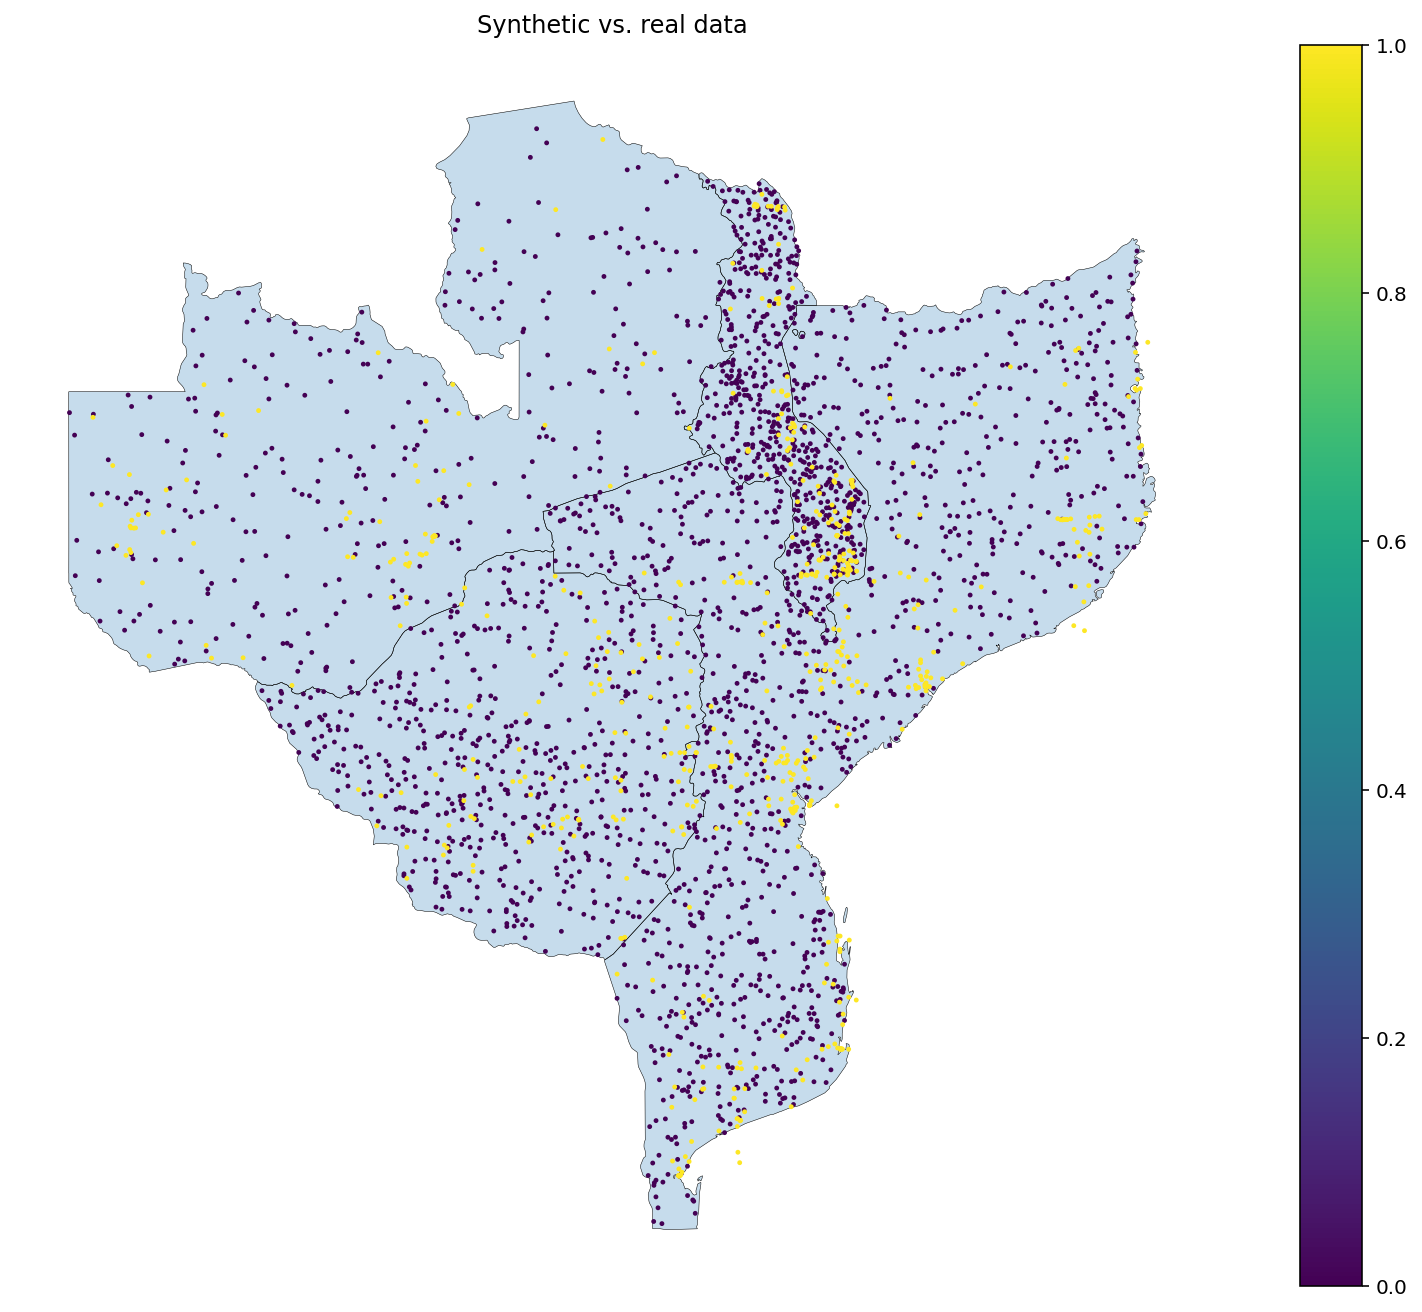

In [12]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @zambia_neighboors ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @zambia_neighboors').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

model_df.query('ISO in @zambia_neighboors').plot("is_disaster",
                                      markersize=2, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [13]:
# Define list of features standardized
features_stand = [feature + "__standardized" for feature in  features]


time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density',
                            'log_population_density_squared','log_gdp_per_cap','log_gdp_per_cap_squared']


time_varying_features_stand = [feature + "__standardized"  for feature in time_varying_features]


### Create WE data sets

In [14]:
#Create the geodata set for sa disasters
z_neib__disasters = model_df.query('ISO in @zambia_neighboors ')

z_neib__disasters_geo = gpd.GeoDataFrame(
                z_neib__disasters,
    geometry=gpd.points_from_xy(z_neib__disasters["long"], z_neib__disasters["lat"]), crs="EPSG:4326"
            )

In [15]:
# Define dfs
z_neib__df = model_df.query('ISO in @zambia_neighboors')

#Tranform dfs to geopandas df
z_neib__df = gpd.GeoDataFrame(z_neib__df,  geometry=gpd.points_from_xy(z_neib__df["long"],
                                z_neib__df["lat"]),crs="EPSG:4326")


In [16]:
# Merge geospatial data with time varying data
country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in zambia_neighboors:
    country_2020_data[country] = z_neib__df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

country_2005_data = {}
country_2005_data_df = pd.DataFrame()
for country in zambia_neighboors:
    country_2005_data[country] = z_neib__df.query('Start_Year == "2005-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
    country_2005_data_df = pd.concat([country_2005_data_df, country_2005_data[country]])

C:\Users\camil\AppData\Local\Temp\ipykernel_35212\1314419082.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = z_neib__df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_35212\1314419082.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = z_neib__df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_35212\1314419082.py:5: FutureWarning: Th

In [64]:
# 2030 data
zmb_forecast = pd.read_csv(here('data/zmb_forecast.csv'))
zmb_forecast.loc[: , "year"] = pd.to_datetime(zmb_forecast["time"], format= "%Y-%m-%d").dt.year

zmb_forecast_2030 = zmb_forecast.query('year ==2030')
zmb_forecast_2030.loc[74, "ISO"] = "ZMB"

# Merge with map
zmb__point_grid_extended_df = gpd.sjoin(zambia_point_grid, z_neib__map, how="left", )
zmb__point_grid_extended_2030 = pd.merge(zmb__point_grid_extended_df, zmb_forecast_2030, how = "left", left_on= "ISO_A3", right_on="ISO" ) 

C:\Users\camil\AppData\Local\Temp\ipykernel_35212\3909238821.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zmb_forecast_2030.loc[74, "ISO"] = "ZMB"


In [65]:
# Merge with map
zmb__point_grid_extended_df = gpd.sjoin(zambia_point_grid, z_neib__map, how="left", )
z_neib__point_grid_extended["2020"] = pd.merge(z_neib__point_grid_extended_df, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 

In [66]:
# Merge points with world ISO
z_neib__point_grid_extended = {}
z_neib__point_grid_extended_df = gpd.sjoin(z_neib__point_grid, z_neib__map, how="left", )
z_neib__point_grid_extended["2020"] = pd.merge(z_neib__point_grid_extended_df, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 
z_neib__point_grid_extended["2005"] = pd.merge(z_neib__point_grid_extended_df, country_2005_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" )


z_neib__point_grid_extended["2020"] = z_neib__point_grid_extended["2020"].rename(columns = {"lon" : "long"})
z_neib__point_grid_extended["2005"] = z_neib__point_grid_extended["2005"].rename(columns = {"lon" : "long"})

In [18]:
# Standardize we data
cols_to_standardize = ['log_distance_to_river','log_distance_to_coastline',
       'log_gdp_per_cap_squared', 'Population', 'log_population_density',
       'log_gdp_per_cap', 'dev_ocean_temp', 'co2', 'precip_deviation',
       'log_population_density_squared' ]

cols_not_stand = ['geometry', "Start_Year", "ISO" , "is_disaster"]
gri_cols_not_stand = ["geometry", 'ISO', "lat", "long"]

# Standardize z_neib__df_stand
transformer_stand_ =  Standardize().fit(z_neib__df[cols_to_standardize] )


z_neib__df_stand = transformer_stand_.transform(z_neib__df[cols_to_standardize] )
z_neib__df_stand = pd.DataFrame(z_neib__df_stand, columns=features_stand, index = z_neib__df.index)
z_neib__df_stand = pd.merge(z_neib__df_stand, z_neib__df[cols_not_stand], left_index= True, right_index= True, how = "left" )

# other dfs
# 2020
z_neib__point_grid_extended_2020 = transformer_stand_.transform( z_neib__point_grid_extended["2020"][cols_to_standardize] ) 
z_neib__point_grid_extended_2020= pd.DataFrame(z_neib__point_grid_extended_2020, columns=features_stand , index =z_neib__point_grid_extended["2020"].index )
z_neib__point_grid_extended["2020"] = pd.merge(z_neib__point_grid_extended_2020, z_neib__point_grid_extended["2020"][gri_cols_not_stand], left_index= True, right_index= True, how = "left" )

# 2005
# other dfs
z_neib__point_grid_extended_2005 = transformer_stand_.transform( z_neib__point_grid_extended["2005"][cols_to_standardize] ) 
z_neib__point_grid_extended_2005 = pd.DataFrame(z_neib__point_grid_extended_2005, columns=features_stand , index =z_neib__point_grid_extended["2005"].index )
z_neib__point_grid_extended["2005"] = pd.merge(z_neib__point_grid_extended_2005, z_neib__point_grid_extended["2005"][gri_cols_not_stand], left_index= True, right_index= True, how = "left" )


# 2023
zmb__point_grid_extended_2030

In [69]:
# 2023
zmb__point_grid_extended_2030_stand =  transformer_stand_.transform( zmb__point_grid_extended_2030[cols_to_standardize] ) 

zmb__point_grid_extended_2030_stand = pd.DataFrame(zmb__point_grid_extended_2030_stand, columns= features_stand , index =zmb__point_grid_extended_2030.index )
zmb__point_grid_extended_2030_stand = pd.merge(zmb__point_grid_extended_2030_stand,zmb__point_grid_extended_2030[gri_cols_not_stand], left_index= True, right_index= True, how = "left" )

# Model on the WE data set: Full model

In [22]:
from laos_gggi.data_functions import load_all_data, load_emdat_data

In [23]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(z_neib__df["is_disaster"])
ISO_idx, ISO = pd.factorize(z_neib__df["ISO"]) 
obs_idx = z_neib__df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(z_neib__df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_sa = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }

In [24]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(z_neib__df["is_disaster"])
ISO_idx, ISO = pd.factorize(z_neib__df["ISO"]) 
obs_idx = z_neib__df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(z_neib__df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_sa = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }

In [25]:
with pm.Model(coords=coords_sa) as model_z_neib__full:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  z_neib__df_stand, )
    ISO_idx_pt = pm.Data("ISO_idx_pt", ISO_idx, dims= ["obs_idx"] )
    
    # #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    #Betas
    beta_sigma = [0.1] * 10
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])

    # HSGP process
    X_gp = pm.Data("X_gp", z_neib__df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 35, 35, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd),dims= ["obs_idx"])


    #Model mu
    mu = pm.Deterministic("mu", country_effect[ISO_idx_pt] +  X@beta + HSGP_component , dims= ["obs_idx"] )
    

    y_hat = pm.Bernoulli('y_hat', logit_p = mu, observed=Y, dims=['obs_idx'])

C:\Users\camil\AppData\Local\Temp\ipykernel_35212\1226387628.py:18: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  ell_params = pm.find_constrained_prior(


In [26]:
if exists("model_z_neib__full.idata"):
    model_z_neib__full_idata = az.from_netcdf("model_z_neib__full.idata")

else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_z_neib__full), backend="jax", gradient_backend='jax')
    model_z_neib__full_idata = nutpie.sample(compiled_model)
    #Save the idata
    az.to_netcdf(data = model_z_neib__full_idata, filename= pathlib.Path("model_z_neib__full.idata"))

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.19,31
,1300,0,0.19,31
,1300,0,0.19,31
,1300,0,0.19,31
,1300,0,0.18,31
,1300,0,0.18,31


### WE predictions

In [27]:
# Rebuild ISO_idx_sa
ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_sa=  z_neib__point_grid_extended['2020'].ISO.map(ISO_to_idx.get)

model_z_neib__full_idata_plot = {}

for year in ["2020", "2005"]:
    with model_z_neib__full.copy() as temp_model:
        #Declare data
        pm.set_data({"X_gp": z_neib__point_grid[["lat", "long"]],
                     "Y": np.full(z_neib__point_grid_extended[year].shape[0], 0 ),
                     "X": z_neib__point_grid_extended[year][features_stand],
                     "ISO_idx_pt": ISO_idx_sa
     
                },
            coords= {"obs_idx": z_neib__point_grid_extended[year].index.values } 
           )
    
        y_hat_invlogit = pm.Deterministic('y_hat_invlogit', pm.math.invlogit(temp_model["y_hat"] ))
    
    
    
    with freeze_dims_and_data(temp_model):
        model_z_neib__full_idata_plot[year] = pm.sample_posterior_predictive(model_z_neib__full_idata, var_names=["y_hat_invlogit","HSGP_component", "y_hat"], 
                                                             compile_kwargs= {"mode" : "JAX" })


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2BE494BAEA0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2BE5929ADC0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

In [28]:
# Create the geopandas version of the predictions
model_z_neib__full_predictions_geo = {}

for year in ["2020", "2005"]:
    model_z_neib__full_predictions_geo[year] = prediction_to_gpd_df(prediction_idata = model_z_neib__full_idata_plot[year] , 
                         variables = ["y_hat_invlogit","HSGP_component", "y_hat"] , 
                         points = z_neib__point_grid_extended['2020'] )

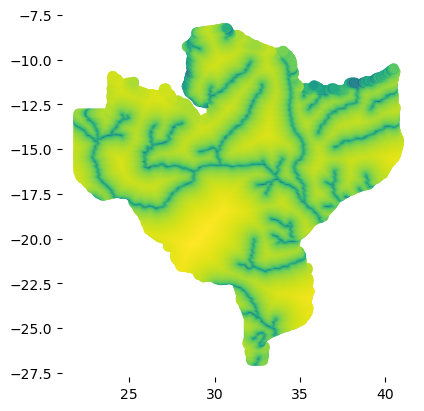

In [29]:
z_neib__point_grid_extended_df.plot("log_distance_to_river");

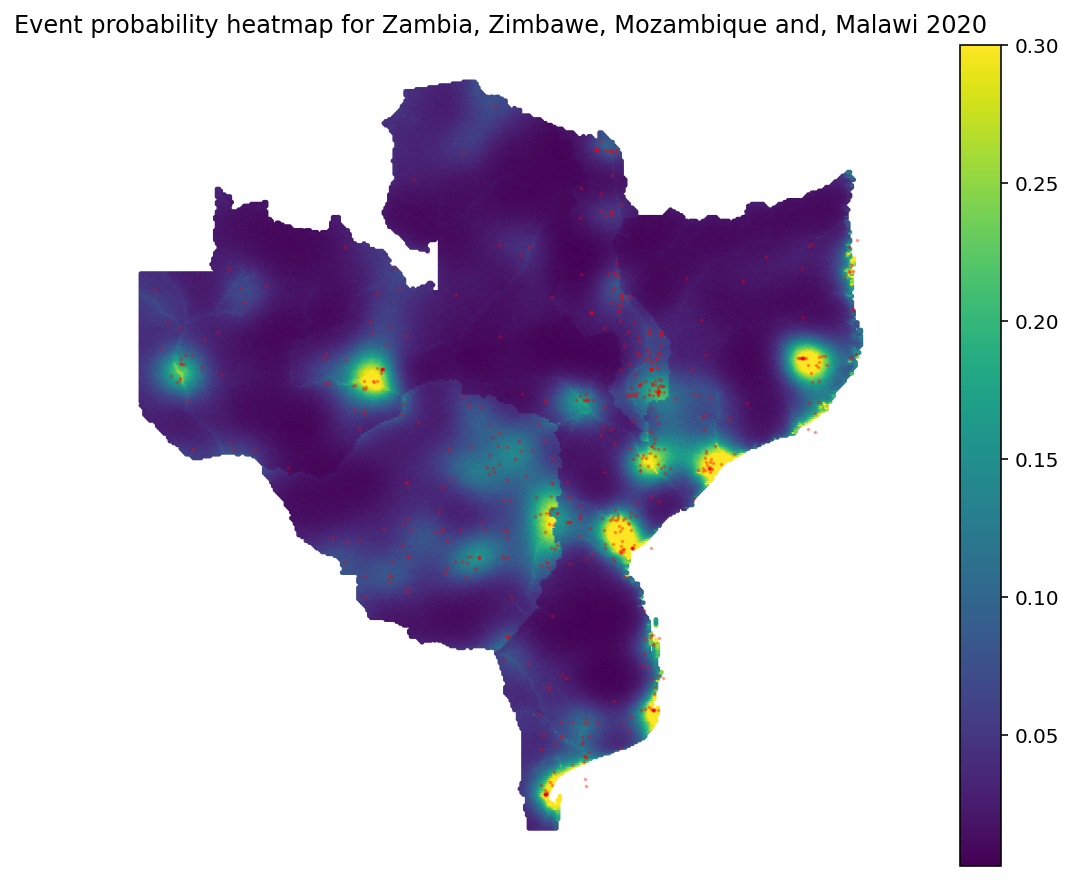

In [126]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
model_z_neib__full_predictions_geo["2020"]["y_hat"].plot("y_hat",legend=True, ax=ax,markersize =2, vmax = 0.3,)
z_neib__disasters_geo.query('is_disaster == 1').plot(ax=ax, alpha = 0.3, c = "r", markersize =0.7, )
plt.title("Event probability heatmap for Zambia, Zimbawe, Mozambique and, Malawi 2020", )

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False);

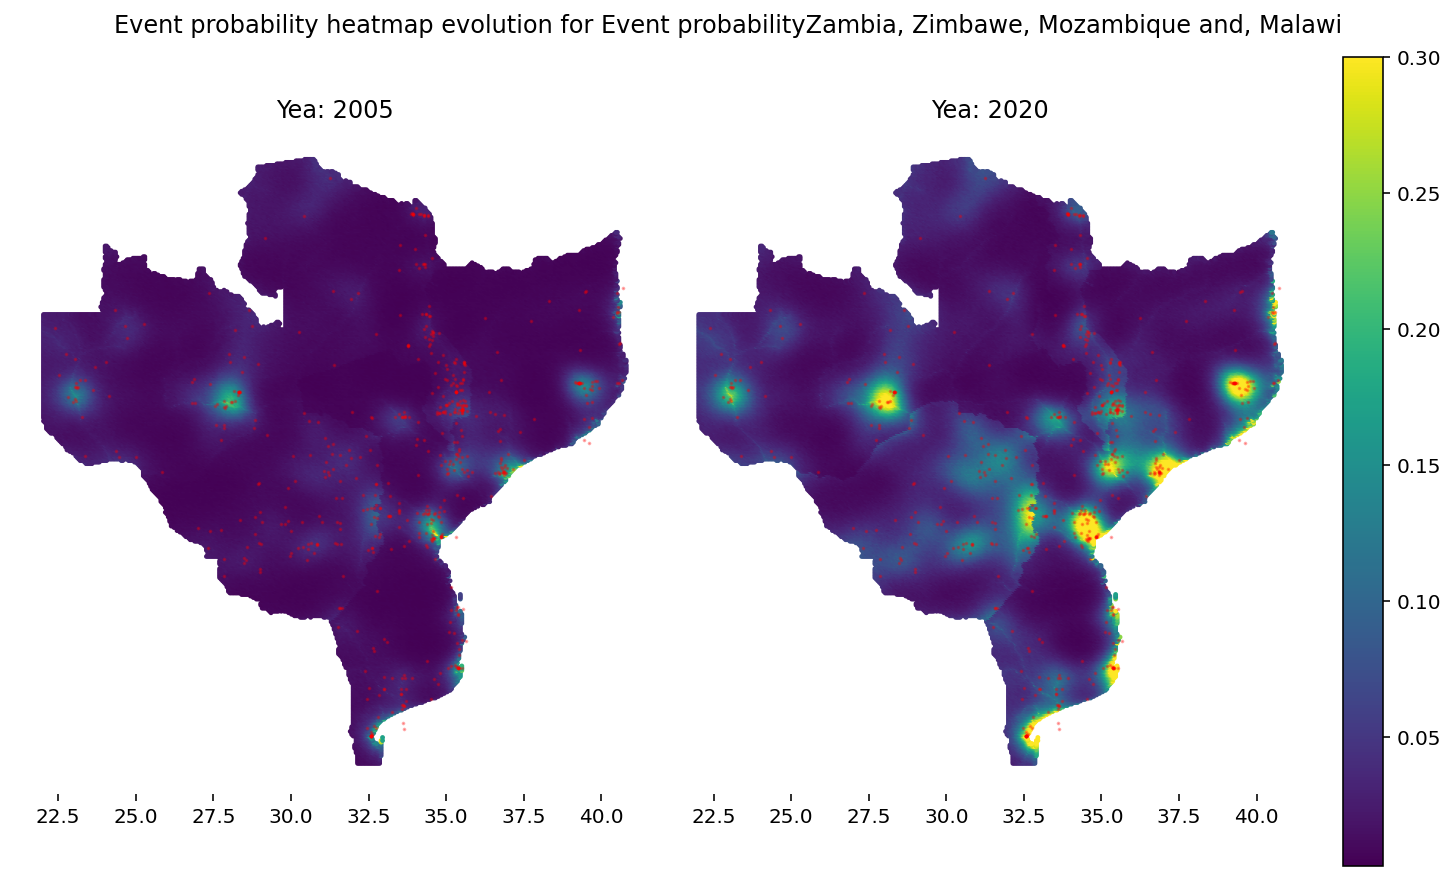

In [122]:
#Plot the predictions
legend =  [False, True ]

fig, ax = plt.subplots(1,2, figsize=(10, 6), dpi= 144, sharey= True )
for year, x in zip([ "2005", "2020"], [0,1]):
    model_z_neib__full_predictions_geo[year]["y_hat"].plot("y_hat",legend=legend[x] , ax=ax[x],markersize =2, vmax = 0.3, )
    
    z_neib__disasters_geo.query('is_disaster == 1').plot(ax=ax[x], alpha = 0.3, c = "r", markersize =0.7, )
    ax[x].get_yaxis().set_visible(False)
    ax[x].set_title(f"Yea: {year}", )
    
plt.suptitle("Event probability heatmap evolution for Event probabilityZambia, Zimbawe, Mozambique and, Malawi");

### Zambia predictions

In [70]:
# Rebuild ISO_idx_sa
ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_sa=  zmb__point_grid_extended_2030_stand.ISO.map(ISO_to_idx.get)

model_zmb__full_idata_plot = {}

with model_z_neib__full.copy() as temp_model:
    #Declare data
    pm.set_data({"X_gp": zmb__point_grid_extended_2030_stand[["lat", "long"]],
                 "Y": np.full(zmb__point_grid_extended_2030_stand.shape[0], 0 ),
                 "X": zmb__point_grid_extended_2030_stand[features_stand],
                 "ISO_idx_pt": ISO_idx_sa
 
            },
        coords= {"obs_idx": zmb__point_grid_extended_2030_stand.index.values } 
       )

    y_hat_invlogit = pm.Deterministic('y_hat_invlogit', pm.math.invlogit(temp_model["y_hat"] ))



with freeze_dims_and_data(temp_model):
    model_zmb__full_idata_plot = pm.sample_posterior_predictive(model_z_neib__full_idata, var_names=["y_hat_invlogit","HSGP_component", "y_hat"], 
                                                         compile_kwargs= {"mode" : "JAX" })


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2BE3F6E9D20>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

In [80]:
zambia_pred ={}
zambia_pred["2030"] = prediction_to_gpd_df(prediction_idata = model_zmb__full_idata_plot , 
                     variables = ["y_hat_invlogit","HSGP_component", "y_hat"] , 
                     points = zmb__point_grid_extended_2030_stand )

for year in ["2005", "2020"]:
    for var in ["y_hat_invlogit","HSGP_component", "y_hat"]:
        zambia_pred[year] = {}
        zambia_pred[year][var] = model_z_neib__full_predictions_geo[year][var].query('ISO == "ZMB"')

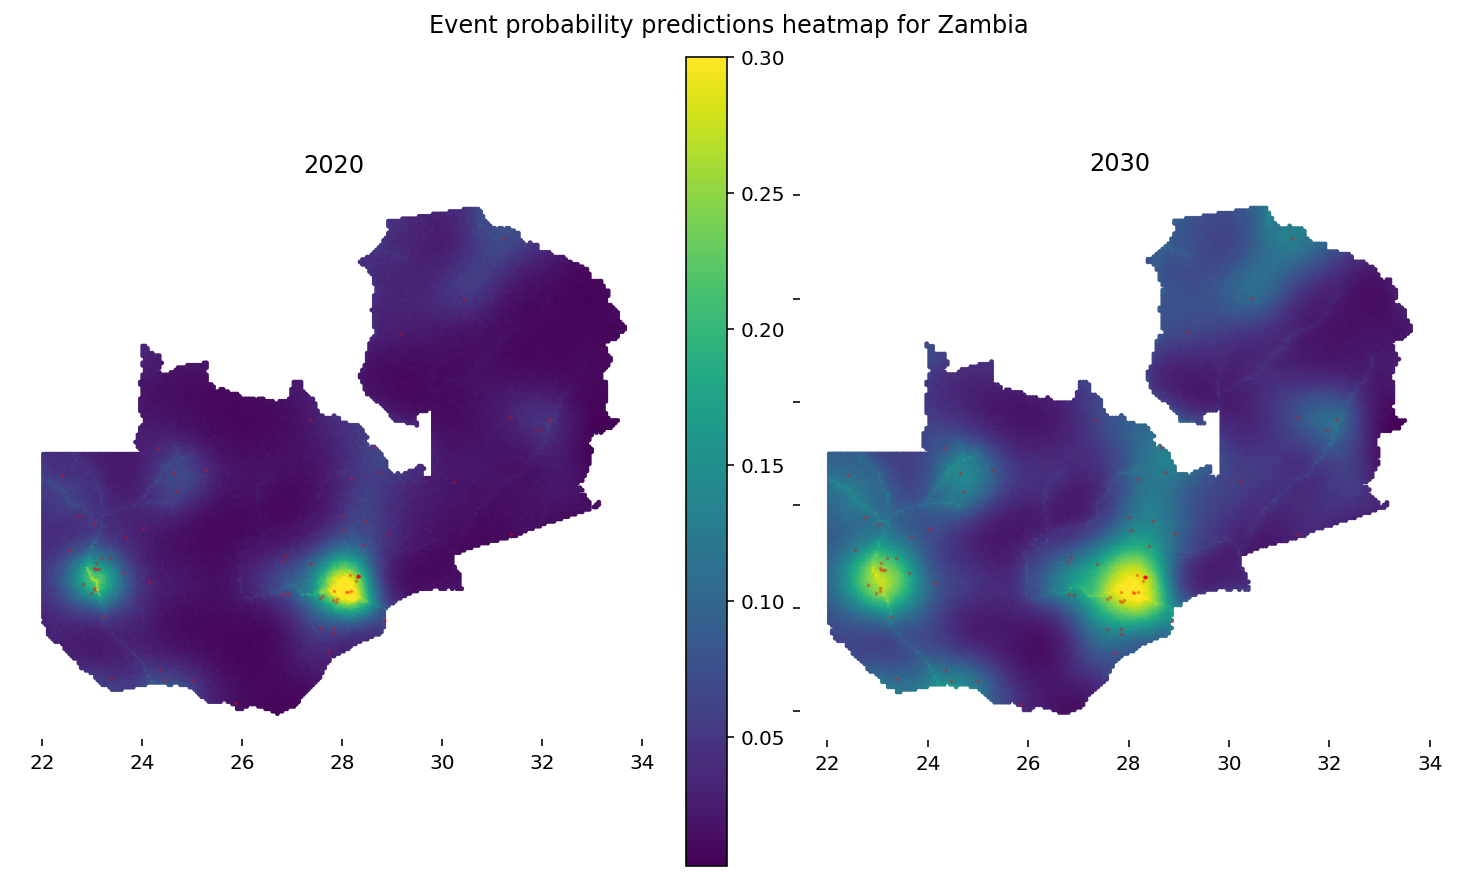

In [123]:
#Plot the predictions
legend = [False, False, True]

fig, ax = plt.subplots(1, 2, figsize=(10, 6), dpi=144, sharey=True)
zambia_pred["2020"]["y_hat"].plot("y_hat", legend=True, ax=ax[0], markersize=2, vmax=0.3)

z_neib__disasters_geo.query('is_disaster == 1').query('ISO == "ZMB"').plot(ax=ax[0], alpha=0.3, c="r", markersize=0.7)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("2020")



zambia_pred["2030"]["y_hat"].plot("y_hat",legend= False , ax=ax[1],markersize =2, vmax = 0.8, )
z_neib__disasters_geo.query('is_disaster == 1').query('ISO == "ZMB"').plot(ax=ax[1], alpha = 0.3, c = "r", markersize =0.7, )
ax[1].set_title("2030")

plt.suptitle("Event probability predictions heatmap for Zambia");